# KNN, рак и спам
__Суммарное количество баллов: 12__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[HSE][ML][MS][HW01] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

В этом домашнем задании Вам предлагается при помощи классификации методом k ближайших соседей научиться отличать тип опухоли в организме, а так же определять сообщения со спамом

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import pandas as pd
from typing import NoReturn, Tuple, List, Optional

### Задание 1 (1 балл)
Для начала работы нам необходимо научиться читать набор данных. Всего мы будем работать с двумя наборами данных.

__Cancer.csv__ - выборка данных о пациентах с доброкачественными и злокачественными опухолями. Задача - научиться их отличать.

__Spam.csv__ - набор данных большего размера. Он содержит некоторую статистику по сообщениям, а так же метку, является ли сообщение спамом. Задача - научиться автоматически отличать спам от обычных сообщений.

Реализуйте методы `read_cancer_dataset` и `read_spam_dataset`. Каждый из них принимает на вход путь к набору данных и возвращает выборку `X` и соответствующие метки `y`. Набор данных должен быть упорядочен случайно, т.е. необходимо сделать shuffle.

In [2]:
def read_cancer_dataset(path_to_csv: str) -> Tuple[np.array, np.array]:
    """
     
    Parameters
    ----------
    path_to_csv : str
        Путь к cancer датасету.

    Returns
    -------
    X : np.array
        Матрица признаков опухолей.
    y : np.array
        Вектор бинарных меток, 1 соответствует доброкачественной опухоли (M), 
        0 --- злокачественной (B).

    
    """
    df = pd.read_csv(path_to_csv).sample(frac=1)
    y = (df.label == "M").values.astype(np.int8)
    X = df.drop("label", axis=1).values
    return X, y

def read_spam_dataset(path_to_csv: str) -> Tuple[np.array, np.array]:
    """
     
    Parameters
    ----------
    path_to_csv : str
        Путь к spam датасету.

    Returns
    -------
    X : np.array
        Матрица признаков сообщений.
    y : np.array
        Вектор бинарных меток, 
        1 если сообщение содержит спам, 0 если не содержит.
    
    """
    df = pd.read_csv(path_to_csv).sample(frac=1)
    y = df.label.values
    X = df.drop("label", axis=1).values
    return X, y

In [3]:
read_cancer_dataset("cancer.csv")

(array([[1.132e+01, 2.708e+01, 7.176e+01, ..., 2.083e-02, 2.849e-01,
         7.087e-02],
        [1.429e+01, 1.682e+01, 9.030e+01, ..., 3.333e-02, 2.458e-01,
         6.120e-02],
        [9.405e+00, 2.170e+01, 5.960e+01, ..., 3.770e-02, 2.872e-01,
         8.304e-02],
        ...,
        [1.300e+01, 2.182e+01, 8.750e+01, ..., 2.060e-01, 4.378e-01,
         1.072e-01],
        [1.049e+01, 1.929e+01, 6.741e+01, ..., 3.203e-02, 2.826e-01,
         7.552e-02],
        [1.528e+01, 2.241e+01, 9.892e+01, ..., 1.226e-01, 3.175e-01,
         9.772e-02]]),
 array([0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0,
        0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1,
        0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0,
        0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
 

### Задание 2  (1 балл)
Начиная работать с данными, нам необходимо их предобработать и подготовить. В частности, нам необходимо разделить выборку на две: тренировочную и тестовую. Тренировочная выборка необходима для обучения алгоритма, а тестовая для проверки результатов обучения. Обычно используют коэффициент разделения `0.9`.

Необходимо вернуть кортеж из `X_train`, `y_train`, `X_test` и `y_test`

In [4]:
def train_test_split(X: np.array, y: np.array, ratio: float
                     ) -> Tuple[np.array, np.array, np.array, np.array]:
    """

    Parameters
    ----------
    X : np.array
        Матрица признаков.
    y : np.array
        Вектор меток.
    ratio : float
        Коэффициент разделения.

    Returns
    -------
    X_train : np.array
        Матрица признаков для train выборки.
    y_train : np.array
        Вектор меток для train выборки.
    X_test : np.array
        Матрица признаков для test выборки.
    y_test : np.array
        Вектор меток для test выборки.

    """
    assert X.shape[0] == y.shape[0]
    assert 0 <= ratio <= 1
    
    split_index = int(X.shape[0] * ratio)
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]
    
    return X_train, y_train, X_test, y_test

### Задание 3 (2 балла)
Также прежде чем приступать к решению задачи, нам необходимо определиться с метриками, которые позволят нам оценить полученное решение. Для задач классификации мы можем использовать precision, recall и accuracy. Эти метрики считаются для каждого класса.

Метод возвращает:

* Вектор __Precision__, каждый из элементов которого равен значению метрики precision для соответствующего класса. 

* Вектор __Recall__, каждый из элементов которого равен значению метрики recall для соответствующего класса.

* __Accuracy__ - число, которое равно отношению правильно классифицированных элементов выборке к размеру выборки.

In [5]:
def get_precision_recall_accuracy(y_pred: np.array, y_true: np.array
                                  ) -> Tuple[np.array, np.array, float]:
    """

    Parameters
    ----------
    y_pred : np.array
        Вектор классов, предсказанных моделью.
    y_true : np.array
        Вектор истинных классов.

    Returns
    -------
    precision : np.array
        Вектор с precision для каждого класса.
    recall : np.array
        Вектор с recall для каждого класса.
    accuracy : float
        Значение метрики accuracy (одно для всех классов).

    """
    assert y_pred.ndim == 1 and y_pred.shape == y_true.shape
    
    accuracy = (y_pred == y_true).sum() / y_pred.shape[0]
    
    labels = np.sort(np.unique(y_true))
    
    actual_positive = y_true == labels[:, None]
    actual_negative = np.logical_not(actual_positive)
    
    pred_positive = y_pred == labels[:, None]
    pred_negative = np.logical_not(pred_positive)
    
    TP = np.logical_and(pred_positive, actual_positive).sum(axis=1)
    FP = np.logical_and(pred_positive, actual_negative).sum(axis=1)
    FN = np.logical_and(pred_negative, actual_positive).sum(axis=1)
    
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    
    precision = np.nan_to_num(precision, nan=0.0)
    recall = np.nan_to_num(recall, nan=0.0)
    
    return precision, recall, accuracy

Теперь, имея этот метод, мы можем построить кривые зависимости Precision, Recall и Accuracy от параметра `k`

In [6]:
def plot_precision_recall(X_train, y_train, X_test, y_test, max_k=30):
    ks = list(range(1, max_k + 1))
    classes = len(np.unique(list(y_train) + list(y_test)))
    precisions = [[] for _ in range(classes)]
    recalls = [[] for _ in range(classes)]
    accuracies = []
    for k in ks:
        classifier = KNearest(k)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in range(classes):
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)
    def plot(x, ys, ylabel, legend=True):        
        plt.figure(figsize = (12, 3))
        plt.xlabel("K")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(ys)-0.01, np.max(ys)+0.01)
        for cls, cls_y in enumerate(ys):
            plt.plot(x, cls_y, label="Class " + str(cls))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()
    
    plot(ks, recalls, "Recall")
    plot(ks, precisions, "Precision")
    plot(ks, [accuracies], "Accuracy", legend=False)

Также для оценки качества классификации построим __ROC-кривую__. Она отражает зависимость __True Positive Rate__ (TPR) от __False Positive Rate__ (FPR) для заранее фиксированного класса. Чем график выше побочной диагонали - тем лучше.

In [7]:
def plot_roc_curve(X_train, y_train, X_test, y_test, max_k=30):
    positive_samples = sum(1 for y in y_test if y == 0)
    ks = list(range(1, max_k + 1))
    curves_tpr = []
    curves_fpr = []
    colors = []
    for k in ks:
        colors.append([k / ks[-1], 0, 1 - k / ks[-1]])
        knearest = KNearest(k)
        knearest.fit(X_train, y_train)
        p_pred = [p[0] for p in knearest.predict_proba(X_test)]
        tpr = []
        fpr = []
        for w in np.arange(-0.01, 1.02, 0.01):
            y_pred = [(0 if p > w else 1) for p in p_pred]
            tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
            fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
        curves_tpr.append(tpr)
        curves_fpr.append(fpr)
    plt.figure(figsize = (7, 7))
    for tpr, fpr, c in zip(curves_tpr, curves_fpr, colors):
        plt.plot(fpr, tpr, color=c)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

### Задание 4 (5 баллов)
Теперь преступим к реализации классификатора. В этот раз будем использовать классификацию методом k средних. Поскольку основной решаемой задачий во время классификации этим методом является поиск ближайших соседей, а набор данных может быть достаточно большим, наивная реализация будет работать очень долго.

Одним из способов решить эту проблему является __KD-дерево__. Оно позволяет значительно ускорить поиск ближайших соседей. Реализуйте построение KD-дерева и выполнение запросов на поиск k ближайших соседей.

Метод `__init__` должен принимать на вход набор точек `X`, по которому будет строиться дерево, а так же размер листов `leaf_size` построенного дерева.

Метод `query` должен принимать на вход набор точек `X`, для каждой из которых необходимо найти `k` ближайших соседей.

In [8]:
class KDNode:
    SplitInfo = Tuple[int, float]  # feature_id, median
    DataPiece = Tuple[np.array, np.array]  # X, indices
    
    def __init__(self, data: DataPiece, leaf_size):
        """

        Parameters
        ----------
        data : DataPiece
            Набор точек и их индексов, по которому строится дерево.
        leaf_size : int
            Минимальный размер листа
            (то есть, пока возможно, пространство разбивается на области, 
            в которых не меньше leaf_size точек).

        Returns
        -------

        """
        res = self._make_split(data, leaf_size)
        self._max_k = data[0].shape[0]
        if res is None:
            self._data = data
            self._split_info = None
            self._children = None
        else:
            splits, split_info = res
            self._data = None
            self._split_info = split_info
            self._children = KDNode(splits[0], leaf_size), KDNode(splits[1], leaf_size)

    @staticmethod
    def _make_split(data: DataPiece, leaf_size: int) \
            -> Optional[Tuple[Tuple[DataPiece, DataPiece], SplitInfo]]:
        X, _ = data

        if X.shape[0] < 2 * leaf_size:
            return None

        # cur_feature = np.argmax(np.std(X, axis=0))
        medians = np.median(X, axis=0)
        masks = X <= medians
        cur_feature = np.argmin(np.sum(masks, axis=0))
        mask_0 = masks[:, cur_feature]
        mask_1 = np.logical_not(mask_0)

        data_0 = data[0][mask_0], data[1][mask_0]
        data_1 = data[0][mask_1], data[1][mask_1]

        if data_0[0].shape[0] == 0 or data_1[0].shape[0] == 0:
            return None

        return (data_0, data_1), (cur_feature, medians[cur_feature])

    @staticmethod
    def _split(data: DataPiece, split_info: SplitInfo) -> Tuple[DataPiece, DataPiece]:
        feature, median = split_info
        X = data[0]

        mask_0 = X[:, feature] <= median
        mask_1 = np.logical_not(mask_0)
        data_0 = data[0][mask_0], data[1][mask_0]
        data_1 = data[0][mask_1], data[1][mask_1]

        return data_0, data_1
            
    
    def query(self, X: np.array, k) -> Tuple[DataPiece, np.array]:
        """

        Parameters
        ----------
        X : np.array
            Набор точек, для которых нужно найти ближайших соседей.
        k : int
            Число ближайших соседей.

        Returns
        -------
        closest_points : np.array with shape (X.shape[0], k, num_features)
        closest_inds : np.array with shape (X.shape[0], k)
            k ближайших точек и их индексы для каждой точки X в порядке возрастания расстояния

        closest_dists : np.array with shape (X.shape[0], k)
            Расстояния до этих k точек для каждой точки из X

        """
        k = min(k, self._max_k)

        # leaf case
        if self._data is not None:
            X_0, inds = self._data
            assert X.shape[1] == X_0.shape[1]

            dists = np.linalg.norm(X[:, None, :] - X_0[None, :, :], axis=-1)
            closest_Xs, closest_inds, closest_dists = KDNode._sort_by_dists(dists, X_0, inds, k)

            assert closest_Xs.shape == (X.shape[0], k, X.shape[1])
            assert closest_inds.shape == (X.shape[0], k)
            assert closest_dists.shape == (X.shape[0], k)
            return (closest_Xs, closest_inds), closest_dists

        data: KDNode.DataPiece = X, np.arange(X.shape[0])
        splits = KDNode._split(data, self._split_info)

        X_left, inds_left = splits[0]
        X_right, inds_right = splits[1]

        result_Xs = np.empty((X.shape[0], k, X.shape[1]), dtype=X.dtype)
        result_inds = np.empty((X.shape[0], k), dtype=np.int64)
        result_dists = np.empty((X.shape[0], k), dtype=np.float32)

        if X_left.shape[0] > 0:
            data, closest_dists_left = self._query_to_child(X_left, k, left_child=True)
            closest_X_0_left, closest_inds_left = data
            result_Xs[inds_left] = closest_X_0_left
            result_inds[inds_left] = closest_inds_left
            result_dists[inds_left] = closest_dists_left
        if X_right.shape[0] > 0:
            data, closest_dists_right = self._query_to_child(X_right, k, left_child=False)
            closest_X_0_right, closest_inds_right = data
            result_Xs[inds_right] = closest_X_0_right
            result_inds[inds_right] = closest_inds_right
            result_dists[inds_right] = closest_dists_right

        return (result_Xs, result_inds), result_dists

    def _query_to_child(self, X: np.array, k: int, left_child: bool) -> Tuple[DataPiece, np.array]:
        child_ind = 0 if left_child else 1
        data, closest_dists = self._children[child_ind].query(X, k)
        closest_X_0, closest_inds = data

        # Check if need to query to another child
        if closest_inds.shape[1] < k:
            # In that case we need to gather points from the neighbour anyway
            should_requery = np.ones(X.shape[0], dtype=np.bool)
        else:
            feature_ind, median = self._split_info
            dists_to_med = np.abs(X[:, feature_ind] - median)
            should_requery = dists_to_med - closest_dists[:, -1] < 0
        if np.any(should_requery):
            data, re_closest_dists = self._children[child_ind^1].query(X[should_requery], k)
            re_closest_X_0, re_closest_inds = data
            # ugly merge :c
            re_closest_dists = np.concatenate((closest_dists[should_requery], re_closest_dists), axis=1)
            re_closest_X_0 = np.concatenate((closest_X_0[should_requery], re_closest_X_0), axis=1)
            re_closest_inds = np.concatenate((closest_inds[should_requery], re_closest_inds), axis=1)
            re_closest_X_0, re_closest_inds, re_closest_dists = \
                KDNode._sort_by_dists(re_closest_dists, re_closest_X_0, re_closest_inds, k)

            if closest_inds.shape[1] < k:
                closest_dists = re_closest_dists
                closest_X_0 = re_closest_X_0
                closest_inds = re_closest_inds
            else:
                closest_dists[should_requery] = re_closest_dists
                closest_X_0[should_requery] = re_closest_X_0
                closest_inds[should_requery] = re_closest_inds

        assert closest_X_0.shape == (X.shape[0], k, X.shape[1])
        assert closest_inds.shape == (X.shape[0], k)
        assert closest_dists.shape == (X.shape[0], k)
        return (closest_X_0, closest_inds), closest_dists

    @staticmethod
    def _sort_by_dists(dists: np.array, X: np.array, inds: np.array, k: int):
        sort_mask = np.argsort(dists, axis=1)
        sorted_dists = np.take_along_axis(dists, sort_mask, axis=1)[:, :k]
        if X.ndim == 2:
            sorted_X = X[sort_mask][:, :k]
            assert sorted_X.ndim == 3
        else:
            sorted_X = np.take_along_axis(X, sort_mask[..., None], axis=1)[:, :k]
            assert sorted_X.ndim == 3
        if inds.ndim == 1:
            sorted_inds = inds[sort_mask][:, :k]
            assert sorted_inds.ndim == 2
        else:
            sorted_inds = np.take_along_axis(inds, sort_mask, axis=1)[:, :k]
            assert sorted_inds.ndim == 2
        return sorted_X, sorted_inds, sorted_dists

In [9]:
class KDTree:
    def __init__(self, X: np.array, leaf_size: int = 40):
        """

        Parameters
        ----------
        X : np.array
            Набор точек, по которому строится дерево.
        leaf_size : int
            Минимальный размер листа
            (то есть, пока возможно, пространство разбивается на области,
            в которых не меньше leaf_size точек).

        Returns
        -------

        """
        data = X, np.arange(X.shape[0])
        self._kdnode = KDNode(data, leaf_size)

    def query(self, X: np.array, k: int = 1) -> List[List]:
        """

        Parameters
        ----------
        X : np.array
            Набор точек, для которых нужно найти ближайших соседей.
        k : int
            Число ближайших соседей.

        Returns
        -------
        list[list]
            Список списков (длина каждого списка k):
            индексы k ближайших соседей для всех точек из X.

        """
        data, dists = self._kdnode.query(X, k)
        return data[1].tolist()

Поскольку данная струкутра данных является сложной, ее стоит протестировать отдельно. Для этого проведем тестирование с небольшим набором случайных точек. Если после выполнение вывод пуст, то KD-дерево скорее всего работает правильно.

In [10]:
def true_closest(X_train, X_test, k):
    result = []
    for x0 in X_test:
        bests = list(sorted([(i, np.linalg.norm(x - x0)) for i, x in enumerate(X_train)], key=lambda x: x[1]))
        bests = [i for i, d in bests]
        result.append(bests[:min(k, len(bests))])
    return result    

X_train = np.random.randn(100, 3)
X_test = np.random.randn(10, 3)
tree = KDTree(X_train, leaf_size=2)
predicted = tree.query(X_test, k=4)
true = true_closest(X_train, X_test, k=4)

if np.sum(np.abs(np.array(np.array(predicted).shape) - np.array(np.array(true).shape))) != 0:
    print("Wrong shape")
else:
    errors = sum([1 for row1, row2 in zip(predicted, true) for i1, i2 in zip(row1, row2) if i1 != i2])
    if errors > 0:
        print("Encounted", errors, "errors")

In [11]:
class StandardScaler:
    def __init__(self):
        self._mean: Optional[np.array] = None
        self._std: Optional[np.array] = None

    def fit(self, X: np.array):
        self._mean = np.mean(X, axis=0)
        self._std = np.std(X, axis=0)

    def transform(self, X: np.array) -> np.array:
        return (X - self._mean) / self._std


### Задание 5  (3 балла)
Осталось реализовать сам классификатор. Реализуйте его, используя KD-дерево.

Метод `__init__` принимает на вход количество соседей, по которым предсказывается класс, и размер листьев KD-дерева.

Метод `fit` должен по набору данных и меток строить классификатор. 

Метод `predict_proba` должен предсказывать веротности классов для заданного набора данных основываясь на классах соседей

In [12]:
class KNearest:
    def __init__(self, n_neighbors: int = 5, leaf_size: int = 30):
        """

        Parameters
        ----------
        n_neighbors : int
            Число соседей, по которым предсказывается класс.
        leaf_size : int
            Минимальный размер листа в KD-дереве.

        """        
        self._n_neighbors = n_neighbors
        self._leaf_size = leaf_size
        self._kdtree: Optional[KDTree] = None
        self._y: Optional[np.array] = None
        self._classes_count: Optional[int] = None
    
    def fit(self, X: np.array, y: np.array) -> NoReturn:
        """

        Parameters
        ----------
        X : np.array
            Набор точек, по которым строится классификатор.
        y : np.array
            Метки точек, по которым строится классификатор.

        """        
        self._kdtree = KDTree(X, self._leaf_size)
        self._y = y
        self._classes_count = len(np.unique(y))

    def predict_proba(self, X: np.array) -> List[np.array]:
        """

        Parameters
        ----------
        X : np.array
            Набор точек, для которых нужно определить класс.
        
        Returns
        -------
        list[np.array]
            Список np.array (длина каждого np.array равна числу классов):
            вероятности классов для каждой точки X.
            

        """
        k = self._n_neighbors
        k_inds = np.array(self._kdtree.query(X, k))

        return [np.bincount(self._y[k_ind], minlength=self._classes_count) / k for k_ind in k_inds]
        
    def predict(self, X: np.array) -> np.array:
        """

        Parameters
        ----------
        X : np.array
            Набор точек, для которых нужно определить класс.
        
        Returns
        -------
        np.array
            Вектор предсказанных классов.
            

        """
        return np.argmax(self.predict_proba(X), axis=1)

Наконец, протестируем наш классификатор на различных наборах данных. Реализация KNearest должна отработать за разумное время.

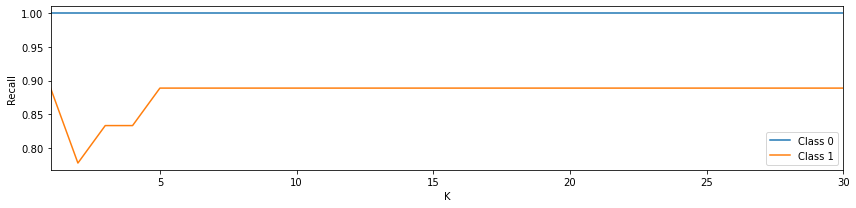

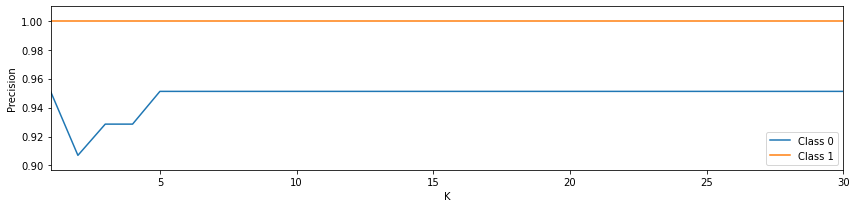

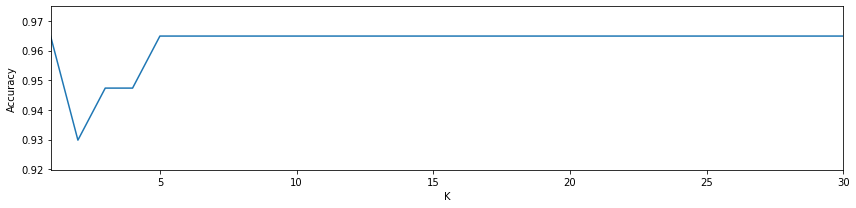

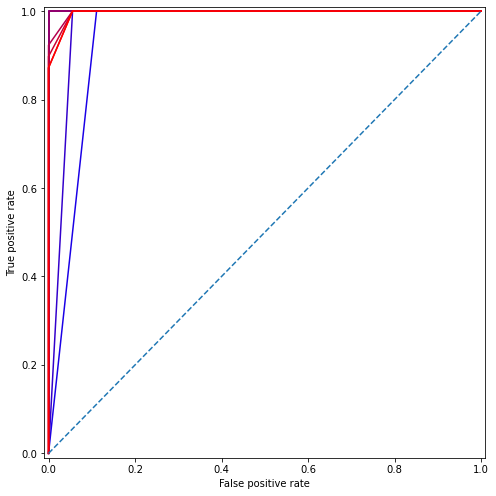

time
CPU times: user 1.48 s, sys: 53.6 ms, total: 1.54 s
Wall time: 1.54 s


In [13]:
%%time

X, y = read_cancer_dataset("cancer.csv")
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
plot_precision_recall(X_train, y_train, X_test, y_test)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=10)

print("time")

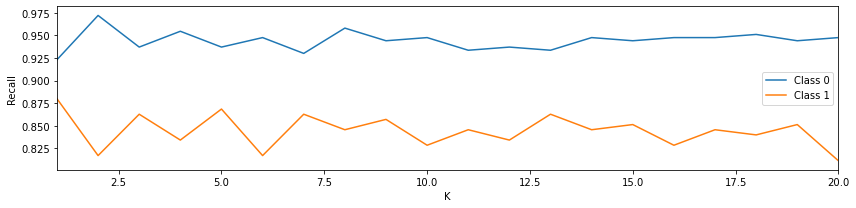

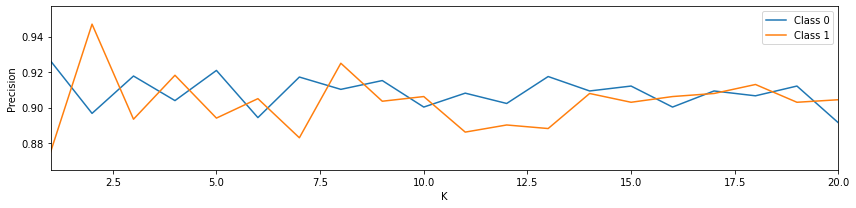

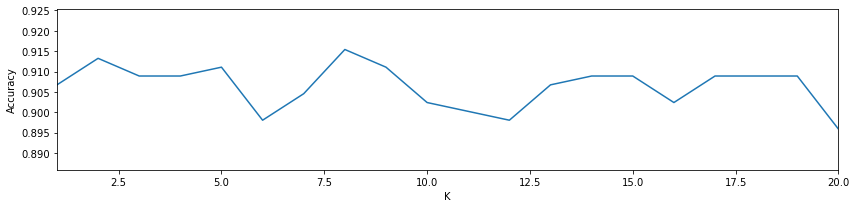

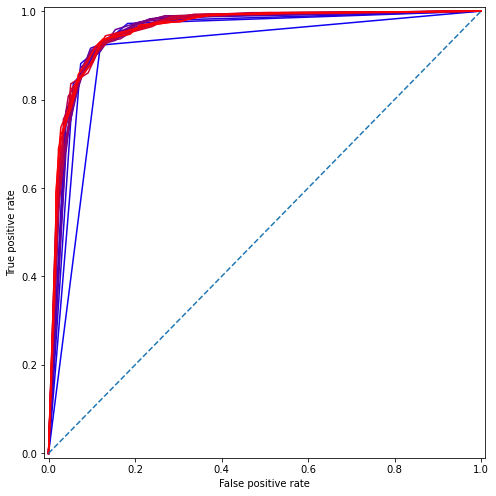

time
CPU times: user 54.7 s, sys: 772 ms, total: 55.5 s
Wall time: 55.5 s


In [14]:
%%time

X, y = read_spam_dataset("spam.csv")
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
plot_precision_recall(X_train, y_train, X_test, y_test, max_k=20)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=20)

print("time")